In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Introduction

Notebook for resampling daily data to monthly frequency, and then carrying out exploratory stats to look for relationships between monthly-aggregated variables. By looking for relationships using monthly-aggregation rather than growing-season aggregation, this analysis highlights relationships that are important for controlling within-year variability as well as intra-annual variability.

Results are reported in Annex A of Jackson-Blake et al. (2022), HESS.

# User input

In [2]:
# File path to daily data
infpath = r'../Data/DataMatrices/Daily/Vansjø_daily_data_Van2_metno.csv'

# Folder to store output csv
out_folder = r'../Data/DataMatrices/Monthly/'

met_source = 'metno'  # 'metno' is the only option here
basin = 'Van2'  # 'Van2' is the only option here

# Read in daily data and resample to monthly frequency

In [3]:
# READ IN
daily_df = pd.read_csv(infpath, index_col=0, parse_dates=True, dayfirst=True)
daily_df.head()

,Pptn,Temp,Wind_speed,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,CyanoBiovol,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,Wind_over_Q0.6,Wind_over_Q0.8,Temp_subzero
Date,,,,,,,,,,,,,,,,
1980-01-01,0.000000,-4.758278,2.9,4.252,NaN,NaN,NaN,NaN,NaN,0,0,False,False,False,False,True
1980-01-02,0.000000,-8.821736,3.1,5.544,NaN,NaN,NaN,NaN,NaN,0,0,False,False,False,False,True
1980-01-03,0.000000,-15.280719,1.5,8.203,NaN,NaN,NaN,NaN,NaN,0,0,True,True,False,False,True
1980-01-04,2.669136,-12.965066,1.7,10.461,NaN,NaN,NaN,NaN,NaN,1,0,True,True,False,False,True
1980-01-05,2.806878,-5.304253,1.5,10.239,NaN,NaN,NaN,NaN,NaN,1,0,True,True,False,False,True


In [4]:
# Set the aggregation method for different variables
vars_to_sum = ["Pptn", "Rain_day", "Pptn_intense", "Q", "Temp_subzero"]

# Add wind cols to vars to sum
wind_cols = []
calm_quantiles = [0.2, 0.4]
windy_quantiles = [0.6, 0.8]
for q in calm_quantiles:
    wind_cols.append("Wind_under_Q%s" % q)
for q in windy_quantiles:
    wind_cols.append("Wind_over_Q%s" % q)
vars_to_sum += wind_cols

vars_to_average = [
    "TP_catch",
    "PTI",
    "Temp",
    "Biovolume",
    "rel_res_time",
    "colour_lake",
    "TP_lake",
    "Wind_speed",
]

vars_to_max = ["CyanoBiovol", "chl-a_lake"]

agg_method_dict = {}  # Key: var, returns aggregation method
for var in daily_df.columns:
    if var in vars_to_sum:
        method = np.sum
    elif var in vars_to_average:
        method = np.nanmean
    elif var in vars_to_max:
        method = np.nanmax
    else:
        method = None
    agg_method_dict[var] = method

In [5]:
monthly_df = daily_df.resample('M').agg(agg_method_dict)

# Summing gives 0 for vars where the whole month was NaNs. Replace with NaN
for sum_var in ["Q", "Pptn"]:
    monthly_df.loc[monthly_df[sum_var] == 0.0, sum_var] = np.NaN

monthly_df.head()

,Pptn,Temp,Wind_speed,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,CyanoBiovol,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,Wind_over_Q0.6,Wind_over_Q0.8,Temp_subzero
Date,,,,,,,,,,,,,,,,
1980-01-31,22.125336,-6.757972,2.319355,70.546,NaN,NaN,NaN,NaN,NaN,5,0,14,17,5,2,31
1980-02-29,32.912846,-7.809669,2.403448,5.184,NaN,NaN,NaN,NaN,NaN,5,1,13,17,5,3,27
1980-03-31,35.959196,-2.712113,3.122581,10.608,NaN,NaN,NaN,NaN,NaN,5,1,8,10,9,3,24
1980-04-30,11.020521,5.377126,3.576667,310.798,130.0,3.971429,45.250000,NaN,NaN,4,0,5,10,11,3,0
1980-05-31,51.422606,12.248917,3.383871,132.962,50.0,12.614286,38.857143,NaN,NaN,8,2,2,11,10,3,0


## Add lagged variables

In [6]:
# For all variables, add 1 month lag
for var in monthly_df.columns:
    monthly_df["%s_lag1M" % var] = monthly_df[var].shift(+1)

# Add a column for the month
monthly_df["Month"] = monthly_df.index.month

monthly_df[["chl-a_lake", "TP_catch", "TP_catch_lag1M"]].head()

,chl-a_lake,TP_catch,TP_catch_lag1M
Date,,,
1980-01-31,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN
1980-04-30,3.971429,130.0,NaN
1980-05-31,12.614286,50.0,130.0


In [7]:
# Means or sums of previous 2-3 months of except the lake vars.
# For the lake variables, the seasonal sampling (only April or May to Sep or Oct) means this
# lagging introduces too many missing values for the analysis

for var in vars_to_sum:
    for months in [2, 3, 4, 5, 6]:
        # First, shift one place so is lagged, then aggregate
        lagged_col = monthly_df[var].shift(+1)
        roll_sum = lagged_col.rolling(months, min_periods=months, closed="right").sum()
        monthly_df["%s_lag%sM_sum" % (var, months)] = roll_sum

# Replave vars_to_average with just non-lake vars, i.e.
for var in ["TP_catch", "Temp", "Q"]:
    for months in [2, 3]:
        # First, shift one place so is lagged, then aggregate
        lagged_col = monthly_df[var].shift(+1)
        roll_mean = lagged_col.rolling(
            months, min_periods=months, closed="right"
        ).mean()
        monthly_df["%s_lag%sM_av" % (var, months)] = roll_mean

monthly_df[["Rain_day", "Rain_day_lag2M_sum", "Rain_day_lag3M_sum"]].head()

,Rain_day,Rain_day_lag2M_sum,Rain_day_lag3M_sum
Date,,,
1980-01-31,5,NaN,NaN
1980-02-29,5,NaN,NaN
1980-03-31,5,10.0,NaN
1980-04-30,4,10.0,15.0
1980-05-31,8,9.0,14.0


## Add values for the previous winter and summer

In [8]:
# For all variables that are summed on aggregating, calculate the sum for the
# previous winter (October - March)

# First, add a 'season_2' column, splitting data into 'winter' (Oct-March) and 'summer' (Apr-Sep)
# N.B. October lake sampling in 'winter' then
def growing_season(month):
    if month < 4 or month > 9:
        return 0
    else:
        return 1


monthly_df["season_2"] = monthly_df.index.month.map(growing_season)

# Then filter to just winter and calculate winter sums per year
wint_sum_df = monthly_df.loc[monthly_df["season_2"] == 0, vars_to_sum]

# Need to take account of fact that one season spans two years
wint_sum_df = wint_sum_df.iloc[3:]  # Drop first 3 values, as only half a season
# Make series of years to sum over (e.g. Oct-Mar of yr-1 to yr)
yr_li = []
for yr in range(1981, 2020):
    a = 6 * [yr]
    yr_li.extend(a)
wint_sum_df["sum_yr"] = yr_li

# Group by years and work out number of months with obs (for filtering
# out years where don't have enough months with obs). And sum!
wint_sum_df_counts = wint_sum_df.groupby("sum_yr").count()
wint_sum_df = wint_sum_df.groupby("sum_yr").sum()

# Add 1980, though it's NaN, for compatibility with monthly df
wint_sum_df.loc[1980] = len(wint_sum_df.columns) * [np.NaN]
wint_sum_df.sort_index(inplace=True)

for var in vars_to_sum:
    monthly_df["%s_winterSum" % var] = monthly_df[var].index.year.map(
        lambda x: wint_sum_df.loc[x, var]
    )

# print monthly_df.loc['1981':'1982',['Rain_day','Rain_day_winterSum']]

In [9]:
# Add mean for previous summer for in-lake ecol variables

prev_summ_vars = [
    "chl-a_lake",
    "TP_lake",
    "CyanoBiovol",
    "colour_lake"
]


# First, RESAMPLE TO SEASONAL
# Define 2 seasons per year, as in 6-month growing season
def season(x):
    """Input month number, and return the season it corresponds to"""
    if x in [11, 12, 1, 2, 3, 4]:
        return "wint"
    else:
        return "summ"


monthly_df["Season"] = monthly_df.index.month.map(season)

# Resample (enter 'Q' for quarterly, and '-month' for month to end in)
# N.B. if you change season function, need to change this too
season_df = daily_df.resample("2Q-Apr", closed="left").agg(agg_method_dict)
season_df["Season"] = season_df.index.month.map(season)

# Map season from previous year to values in current year for summer months
summer_df = season_df.loc[season_df["Season"] == "summ", prev_summ_vars]
summer_df["Year+1"] = summer_df.index.year + 1

for var in prev_summ_vars:
    for idx in monthly_df.index:
        # First year with data is 1980, so no values for previous year. In this case, add NaNs
        if idx.year < 1981:
            prev_summer_val = np.nan
        else:
            prev_summer_val = summer_df[var].loc[summer_df["Year+1"] == idx.year].values

        monthly_df.loc[idx, "%s_prevSummer" % var] = prev_summer_val


monthly_df[
    ["TP_lake", "TP_lake_prevSummer"]
].head(13)

,TP_lake,TP_lake_prevSummer
Date,,
1980-01-31,NaN,NaN
1980-02-29,NaN,NaN
1980-03-31,NaN,NaN
1980-04-30,45.250000,NaN
1980-05-31,38.857143,NaN
1980-06-30,32.633333,NaN
1980-07-31,36.761905,NaN
1980-08-31,67.400000,NaN
1980-09-30,33.857143,NaN


# Write monthly data to csv

In [10]:
# Output to csv
monthly_df.to_csv(
    os.path.join(out_folder, "Vansjø_monthly_data_%s.csv" % basin), index_label="Date"
)

# Quick look at the monthly data

In [11]:
monthly_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pptn,474.0,76.272434,45.474029,0.298019,43.257418,68.903481,103.468893,296.741329
Temp,474.0,6.847922,7.432463,-10.691768,0.748379,6.365612,13.347895,21.546278
Wind_speed,474.0,3.493552,0.641208,0.200000,3.109839,3.515000,3.896667,5.748387
Q,367.0,147.648087,134.938898,2.475000,47.146500,114.722000,204.933500,1020.944000
TP_catch,391.0,81.162981,71.385602,18.000000,38.600000,55.333333,100.628571,646.000000
...,...,...,...,...,...,...,...,...
Wind_over_Q0.8_winterSum,462.0,39.818182,11.016919,16.000000,33.000000,40.000000,45.000000,66.000000
chl-a_lake_prevSummer,450.0,26.746667,10.669034,10.500000,17.366667,26.500000,31.000000,57.000000
TP_lake_prevSummer,450.0,29.373917,5.206219,18.666667,26.560000,29.450000,32.366667,43.573016
CyanoBiovol_prevSummer,270.0,1.976613,1.926093,0.079000,0.258000,0.982000,3.588000,5.960000


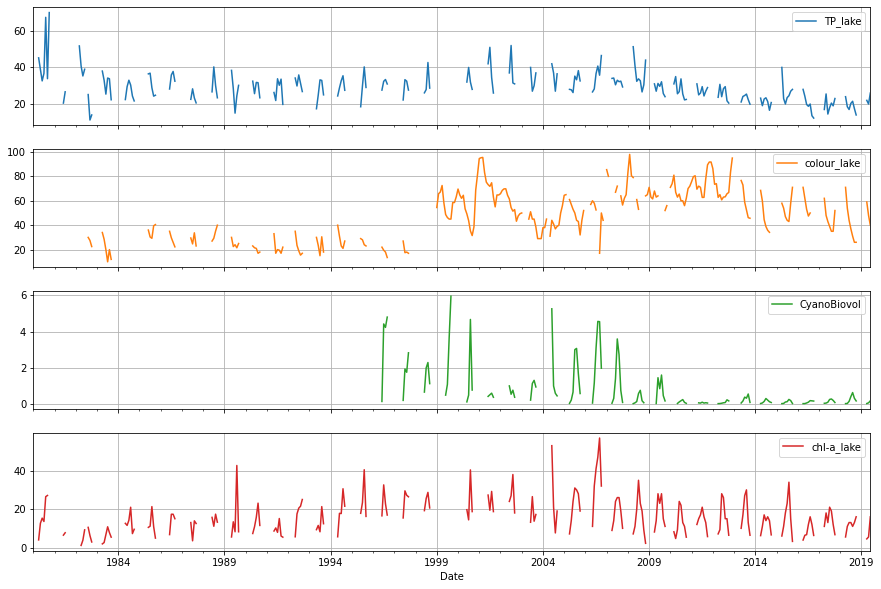

In [12]:
monthly_df[
    ["TP_lake", "colour_lake", "CyanoBiovol", "chl-a_lake"]
].plot(subplots=True, grid=True, figsize=(15, 10));

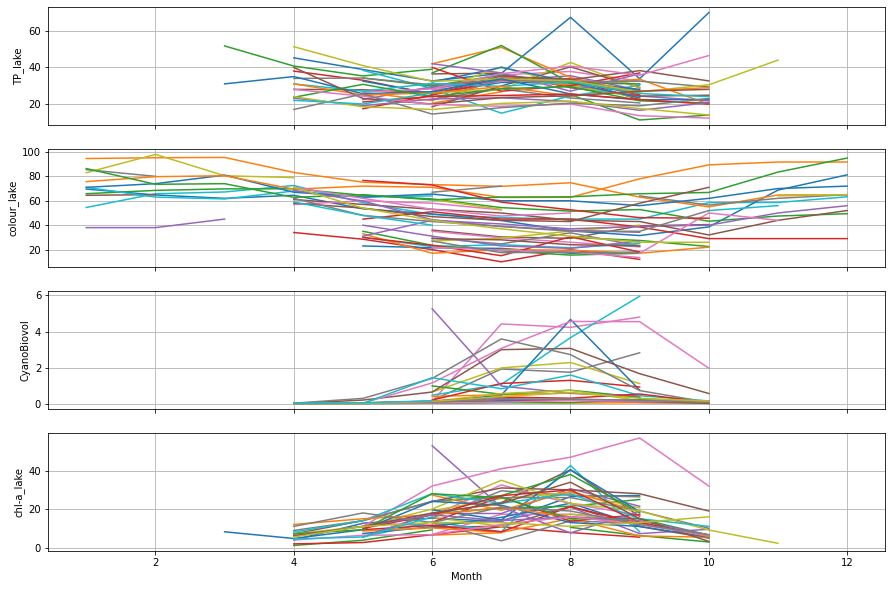

In [13]:
# Plot within-year variability for all years overlapping, to see e.g. how
# variable the seasonal pattern is from year to year

monthly_df_slice = monthly_df[
    ["TP_lake", "colour_lake", "CyanoBiovol", "chl-a_lake"]
]

fig, axs = plt.subplots(
    len(monthly_df_slice.columns), sharex=True, sharey=False, figsize=(15, 10)
)

for group in monthly_df_slice.groupby(monthly_df_slice.index.year):
    year = group[0]
    year_df = group[1]
    year_df = year_df.set_index(year_df.index.month)
    year_df.rename_axis("Month", axis="index", inplace=True)

    for i, var in enumerate(year_df.columns):
        year_df[var].plot(ax=axs[i])

for i, var in enumerate(year_df.columns):
    axs[i].set_ylabel(var)
    axs[i].grid(visible=True, axis="both")

# Split into separate matrices for the 4 possible response variables & look at correlations

In [14]:
sorted(monthly_df.columns)

['CyanoBiovol',
 'CyanoBiovol_lag1M',
 'CyanoBiovol_prevSummer',
 'Month',
 'Pptn',
 'Pptn_intense',
 'Pptn_intense_lag1M',
 'Pptn_intense_lag2M_sum',
 'Pptn_intense_lag3M_sum',
 'Pptn_intense_lag4M_sum',
 'Pptn_intense_lag5M_sum',
 'Pptn_intense_lag6M_sum',
 'Pptn_intense_winterSum',
 'Pptn_lag1M',
 'Pptn_lag2M_sum',
 'Pptn_lag3M_sum',
 'Pptn_lag4M_sum',
 'Pptn_lag5M_sum',
 'Pptn_lag6M_sum',
 'Pptn_winterSum',
 'Q',
 'Q_lag1M',
 'Q_lag2M_av',
 'Q_lag2M_sum',
 'Q_lag3M_av',
 'Q_lag3M_sum',
 'Q_lag4M_sum',
 'Q_lag5M_sum',
 'Q_lag6M_sum',
 'Q_winterSum',
 'Rain_day',
 'Rain_day_lag1M',
 'Rain_day_lag2M_sum',
 'Rain_day_lag3M_sum',
 'Rain_day_lag4M_sum',
 'Rain_day_lag5M_sum',
 'Rain_day_lag6M_sum',
 'Rain_day_winterSum',
 'Season',
 'TP_catch',
 'TP_catch_lag1M',
 'TP_catch_lag2M_av',
 'TP_catch_lag3M_av',
 'TP_lake',
 'TP_lake_lag1M',
 'TP_lake_prevSummer',
 'Temp',
 'Temp_lag1M',
 'Temp_lag2M_av',
 'Temp_lag3M_av',
 'Temp_subzero',
 'Temp_subzero_lag1M',
 'Temp_subzero_lag2M_sum',
 'Te

## Response var = lake TP concentration

In [15]:
# First, lake TP concentration is the explanatory variable.
# So drop all ecological-related stuff. Biol could use up P, and therefore have
# a negative relationship with TP. But correlations are all positive (i.e.
# relationship seems to be the other way around), so remove for
# simplicity. Also drop relative residence time, as it's a function of Q, and
# not looking particularly important compared to Q

cols_to_drop = [
    "chl-a_lake",
    "chl-a_lake_prevSummer",
    "colour_lake",
    "colour_lake_prevSummer",
    "CyanoBiovol",
    "CyanoBiovol_prevSummer",
]

monthly_df_lakeTP = monthly_df.drop(cols_to_drop, axis=1)
print(len(monthly_df_lakeTP))

# Drop any rows where TP_lake is a NaN
monthly_df_lakeTP.dropna(subset=["TP_lake"], inplace=True)
print(len(monthly_df_lakeTP))
monthly_df_lakeTP.head()

474
215


,Pptn,Temp,Wind_speed,Q,TP_catch,TP_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,...,Rain_day_winterSum,Pptn_intense_winterSum,Q_winterSum,Temp_subzero_winterSum,Wind_under_Q0.2_winterSum,Wind_under_Q0.4_winterSum,Wind_over_Q0.6_winterSum,Wind_over_Q0.8_winterSum,Season,TP_lake_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-04-30,11.020521,5.377126,3.576667,310.798,130.0,45.250000,4,0,5,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wint,NaN
1980-05-31,51.422606,12.248917,3.383871,132.962,50.0,38.857143,8,2,2,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,summ,NaN
1980-06-30,131.169901,16.401208,3.016667,146.797,80.0,32.633333,16,4,9,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,summ,NaN
1980-07-31,52.140479,17.528245,2.900000,76.716,75.0,36.761905,14,0,6,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,summ,NaN
1980-08-31,90.301162,15.319784,3.141935,57.546,70.0,67.400000,13,2,3,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,summ,NaN


In [16]:
X = monthly_df_lakeTP.drop(['TP_lake'], axis=1)
y = monthly_df_lakeTP['TP_lake']
corr_df = X.corrwith(y)
corr_df.sort_values()

Wind_over_Q0.6_winterSum    -0.222961
Wind_over_Q0.6_lag6M_sum    -0.176154
Wind_over_Q0.6              -0.172451
Wind_over_Q0.8_lag6M_sum    -0.160344
Wind_speed                  -0.160114
                               ...   
Wind_under_Q0.2_lag6M_sum    0.298010
Wind_under_Q0.2_winterSum    0.313381
CyanoBiovol_lag1M            0.424630
TP_lake_prevSummer           0.452678
TP_lake_lag1M                0.523253
Length: 91, dtype: float64

In [17]:
# monthly_df_lakeTP.to_csv(os.path.join(out_folder,'dataMatrix_monthly_TP_%s.csv'%basin), index_label='Date')

## Response var = Lake chl-a concentration

In [18]:
# 2) chl-a concentration
# cols to drop:
cols_to_drop = ["CyanoBiovol", "CyanoBiovol_prevSummer", "Temp_subzero"]

monthly_df_lake_chla = monthly_df.drop(cols_to_drop, axis=1)
print(len(monthly_df_lake_chla))

# Drop any rows where explanatory variable value is a NaN
monthly_df_lake_chla.dropna(subset=["chl-a_lake"], inplace=True)
print(len(monthly_df_lake_chla))

474
212


In [19]:
X = monthly_df_lake_chla.drop(["chl-a_lake"], axis=1)
y = monthly_df_lake_chla["chl-a_lake"]
corr_df = X.corrwith(y)
corr_df.sort_values()

Q_lag1M                  -0.356202
Q                        -0.346022
Temp_subzero_lag3M_sum   -0.330505
Temp_subzero_lag2M_sum   -0.305776
Temp_subzero_lag4M_sum   -0.278227
                            ...   
CyanoBiovol_lag1M         0.397423
Temp_lag2M_av             0.398983
Temp_lag1M                0.485815
chl-a_lake_lag1M          0.499575
Temp                      0.503983
Length: 94, dtype: float64

In [20]:
# monthly_df_lake_chla.to_csv(os.path.join(out_folder,'dataMatrix_monthly_Chl-a_%s.csv'%basin), index_label='Date')

## Response var = cyanobacterial biovolume

In [21]:
# cols to drop:
cols_to_drop = ["Temp_subzero"]

monthly_df_cyano = monthly_df.drop(cols_to_drop, axis=1)
print(len(monthly_df_cyano))

# Drop any rows where explanatory var value is a NaN
monthly_df_cyano.dropna(subset=["CyanoBiovol"], inplace=True)
print(len(monthly_df_cyano))
# monthly_df_lake_chla.head()

474
132


In [22]:
X = monthly_df_cyano.drop(["CyanoBiovol"], axis=1)
y = monthly_df_cyano["CyanoBiovol"]
corr_df = X.corrwith(y)
corr_df.sort_values()

colour_lake                -0.427680
colour_lake_lag1M          -0.416162
colour_lake_prevSummer     -0.389556
Wind_over_Q0.6_winterSum   -0.341142
Q_lag1M                    -0.302066
                              ...   
CyanoBiovol_prevSummer      0.388745
TP_lake                     0.412596
chl-a_lake_lag1M            0.463372
CyanoBiovol_lag1M           0.630667
chl-a_lake                  0.711366
Length: 96, dtype: float64

In [23]:
# monthly_df_cyano.to_csv(os.path.join(out_folder,'dataMatrix_monthly_CyanoBiovol_%s.csv'%basin), index_label='Date')

## Response var = Lake colour

In [24]:
# Drop all ecological-related stuff

cols_to_drop = [
    "CyanoBiovol",
    "CyanoBiovol_prevSummer",
    "Season",
    "TP_catch",
    "TP_lake",
    "TP_lake_prevSummer",
    "chl-a_lake",
    "chl-a_lake_prevSummer",
    "Temp_subzero",
]

monthly_df_lakeColour = monthly_df.drop(cols_to_drop, axis=1)
print(len(monthly_df_lakeColour))

# Drop any rows where response var is a NaN
monthly_df_lakeColour.dropna(subset=["colour_lake"], inplace=True)
print(len(monthly_df_lakeColour))
monthly_df_lakeColour.head()

474
262


,Pptn,Temp,Wind_speed,Q,colour_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,Wind_over_Q0.6,...,Pptn_winterSum,Rain_day_winterSum,Pptn_intense_winterSum,Q_winterSum,Temp_subzero_winterSum,Wind_under_Q0.2_winterSum,Wind_under_Q0.4_winterSum,Wind_over_Q0.6_winterSum,Wind_over_Q0.8_winterSum,colour_lake_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1982-08-31,106.105606,16.677720,3.861290,6.304,30.0,14,3,3,10,13,...,460.820779,70.0,15.0,902.953,92.0,55.0,91.0,60.0,36.0,NaN
1982-09-30,113.641958,12.174493,4.106667,53.498,27.5,12,6,2,6,16,...,460.820779,70.0,15.0,902.953,92.0,55.0,91.0,60.0,36.0,NaN
1982-10-31,81.748900,7.001845,3.709677,174.715,22.5,13,2,6,12,16,...,460.820779,70.0,15.0,902.953,92.0,55.0,91.0,60.0,36.0,NaN
1983-04-30,53.572295,5.721539,3.393333,242.129,34.0,11,1,3,12,7,...,524.587075,70.0,15.0,1368.602,56.0,46.0,72.0,86.0,53.0,26.666667
1983-05-31,99.419018,10.873511,3.841935,166.803,28.5,14,2,1,10,10,...,524.587075,70.0,15.0,1368.602,56.0,46.0,72.0,86.0,53.0,26.666667


In [25]:
X = monthly_df_lakeColour.drop(["colour_lake"], axis=1)
y = monthly_df_lakeColour["colour_lake"]
corr_df = X.corrwith(y)
corr_df.sort_values()

Temp_lag1M               -0.543948
Temp_lag2M_av            -0.510128
Temp                     -0.499769
Temp_lag3M_av            -0.437120
season_2                 -0.413661
                            ...   
Pptn_intense_lag5M_sum    0.572713
Pptn_lag6M_sum            0.596816
Pptn_intense_lag6M_sum    0.602252
colour_lake_prevSummer    0.715261
colour_lake_lag1M         0.929429
Length: 89, dtype: float64

In [26]:
# monthly_df_lakeColour.to_csv(os.path.join(out_folder,'dataMatrix_monthly_colour_lake_%s.csv'%basin), index_label='Date')